In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
stm = pd.read_pickle('Stemmed.pkl')

In [ ]:
stm.head()

,label,processed_text
0,neutral,fbi crime scene investig document evid outsid ...
1,neutral,hire surg februari econom activ pick case stea...
2,neutral,manhattan district attorney conven grand juri ...
3,neutral,imag sourc afpimag caption mr merkel gave news...
4,neutral,rigger load net full balloon republican nation...


In [ ]:
# Label encode
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
stm['label'] = le.fit_transform(stm['label'])

In [ ]:
from sklearn.utils import resample

# Resampling
majority = stm[stm['label'] == 1]
minority = stm[stm['label'] == 0]

# Middle Calculation
middle = (len(majority) + len(minority))/2
print(middle)

# Resampling
majority_downsampled = resample(majority, replace=False, n_samples=int(middle), random_state=101)
minority_upsampled = resample(minority, replace=True, n_samples=int(middle), random_state=101)

# Concatenation and shuffling
stm = pd.concat([majority_downsampled, minority_upsampled])
stm = stm.sample(frac=1, random_state=101).reset_index(drop=True)

# Label Check
stm['label'].value_counts()

11181.0


,count
label,
0,11181
1,11181


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Converting to DTM
cv = CountVectorizer(stop_words='english')

sdtm = cv.fit_transform(stm['processed_text'])

## Modeling

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input, Reshape

In [ ]:
X = sdtm
y = stm['label']

In [ ]:
# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

sel_k = 10000
selector = SelectKBest(chi2, k=sel_k)
X_new = selector.fit_transform(X, y)

In [ ]:
# Pickle selector
import pickle
# pickle.dump(selector, open('selector.pkl', 'wb'))

In [ ]:
# Dimensionality Reduction
from sklearn.decomposition import TruncatedSVD

in_size = 1200 # DO NOT DO 5000 OR HIGHER
svd = TruncatedSVD(n_components=in_size)
X_new = svd.fit_transform(X_new)

In [ ]:
# Pickle svd
# pickle.dump(svd, open('svd.pkl', 'wb'))

In [ ]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

In [ ]:
# Early Stopping
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True
)


from keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

### Architecture 1

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(128, input_dim=in_size, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    batch_size=32
)

Epoch 1/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6283 - loss: 0.7016 - val_accuracy: 0.7729 - val_loss: 0.5015 - learning_rate: 0.0010
Epoch 2/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7636 - loss: 0.5100 - val_accuracy: 0.8330 - val_loss: 0.4043 - learning_rate: 0.0010
Epoch 3/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8319 - loss: 0.3972 - val_accuracy: 0.8448 - val_loss: 0.3674 - learning_rate: 0.0010
Epoch 4/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8640 - loss: 0.3283 - val_accuracy: 0.8580 - val_loss: 0.3425 - learning_rate: 0.0010
Epoch 5/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8831 - loss: 0.2951 - val_accuracy: 0.8710 - val_loss: 0.3273 - learning_rate: 0.0010
Epoch 6/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9030 - loss: 0.2498 - val_accuracy: 0.8755 - val_loss: 0.3177 - learning_rate: 0.0010
Epoch 7/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9176 - loss: 0.

In [ ]:
# Model evaluation (sel_k = 10000, size = 1200, epochs=24 (with early stop))
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9085 - loss: 0.4672
Test Loss: 0.49042561650276184, Test Accuracy: 0.9063268303871155


In [ ]:
# Pickle the model
import pickle
pickle.dump(model, open('ANN.pkl', 'wb'))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(128, input_dim=in_size, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    batch_size=32
)

Epoch 1/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6199 - loss: 0.7264 - val_accuracy: 0.7753 - val_loss: 0.5058 - learning_rate: 0.0010
Epoch 2/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7534 - loss: 0.5185 - val_accuracy: 0.8314 - val_loss: 0.4115 - learning_rate: 0.0010
Epoch 3/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8242 - loss: 0.4140 - val_accuracy: 0.8507 - val_loss: 0.3717 - learning_rate: 0.0010
Epoch 4/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8585 - loss: 0.3455 - val_accuracy: 0.8509 - val_loss: 0.3568 - learning_rate: 0.0010
Epoch 5/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8818 - loss: 0.2898 - val_accuracy: 0.8688 - val_loss: 0.3371 - learning_rate: 0.0010
Epoch 6/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8949 - loss: 0.2635 - val_accuracy: 0.8768 - val_loss: 0.3304 - learning_rate: 0.0010
Epoch 7/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9082 - loss: 0.

In [ ]:
# Model evaluation (sel_k = 10000, size = 1200, epochs=24 (with early stop))
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9069 - loss: 0.4954
Test Loss: 0.5165852904319763, Test Accuracy: 0.9027498364448547


In [ ]:
predictions = []
for pred in model.predict(X_test):
    if pred > 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Classification Report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))


              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2231
           1       0.91      0.90      0.90      2242

    accuracy                           0.90      4473
   macro avg       0.90      0.90      0.90      4473
weighted avg       0.90      0.90      0.90      4473

[[2027  204]
 [ 231 2011]]


Text(0, 0.5, 'Accuracy')

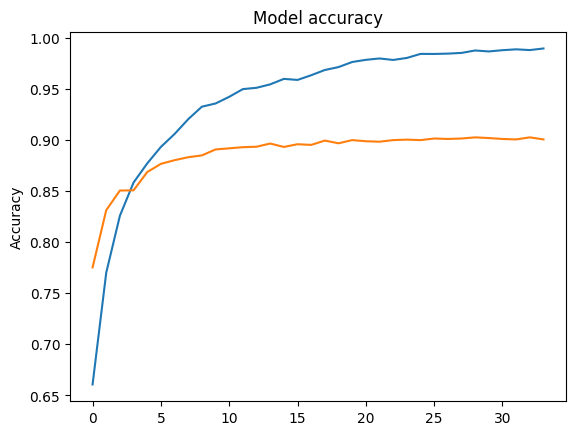

In [ ]:
# Generate a graph to visualize learning over epochs
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')

### Architecture 2

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(8, input_dim=in_size, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(16, input_dim=in_size, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))


# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    batch_size=32
)

Epoch 1/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6322 - loss: 0.6571 - val_accuracy: 0.7534 - val_loss: 0.5562 - learning_rate: 0.0010
Epoch 2/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7533 - loss: 0.5424 - val_accuracy: 0.7811 - val_loss: 0.5158 - learning_rate: 0.0010
Epoch 3/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7989 - loss: 0.4821 - val_accuracy: 0.7932 - val_loss: 0.4944 - learning_rate: 0.0010
Epoch 4/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8148 - loss: 0.4522 - val_accuracy: 0.8109 - val_loss: 0.4726 - learning_rate: 0.0010
Epoch 5/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8246 - loss: 0.4365 - val_accuracy: 0.8122 - val_loss: 0.4763 - learning_rate: 0.0010
Epoch 6/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8344 - loss: 0.4226 - val_accuracy: 0.8236 - val_loss: 0.4497 - learning_rate: 0.0010
Epoch 7/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8360 - loss: 0.

In [ ]:
# Model evaluation (sel_k = 10000, size = 1200, epochs=48 (with early stop))
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8473 - loss: 0.4312
Test Loss: 0.43665021657943726, Test Accuracy: 0.841269850730896


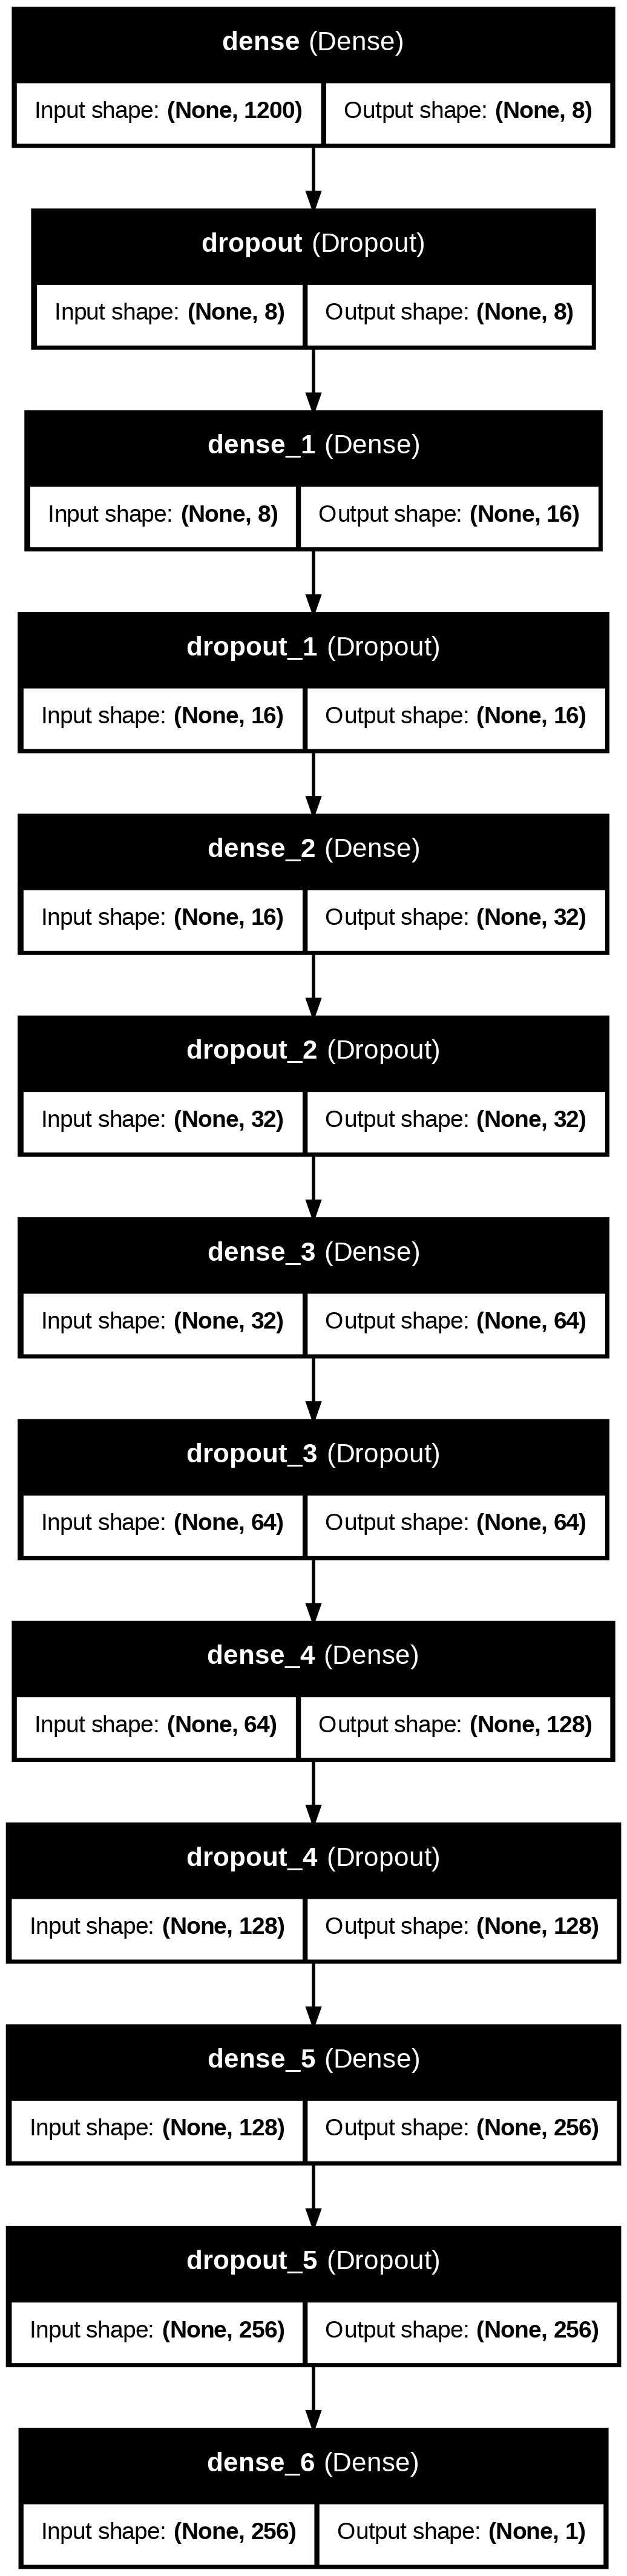

In [ ]:
# Model Architecture Visualization
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Architecture 3

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(64, input_dim=in_size, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    batch_size=32
)

Epoch 1/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6039 - loss: 0.7083 - val_accuracy: 0.7436 - val_loss: 0.5521 - learning_rate: 0.0010
Epoch 2/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7319 - loss: 0.5550 - val_accuracy: 0.8205 - val_loss: 0.4366 - learning_rate: 0.0010
Epoch 3/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8050 - loss: 0.4422 - val_accuracy: 0.8384 - val_loss: 0.3952 - learning_rate: 0.0010
Epoch 4/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8381 - loss: 0.3797 - val_accuracy: 0.8516 - val_loss: 0.3707 - learning_rate: 0.0010
Epoch 5/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8651 - loss: 0.3349 - val_accuracy: 0.8556 - val_loss: 0.3583 - learning_rate: 0.0010
Epoch 6/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8815 - loss: 0.3039 - val_accuracy: 0.8638 - val_loss: 0.3439 - learning_rate: 0.0010
Epoch 7/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8988 - loss: 0.

In [ ]:
# Model evaluation (sel_k = 10000, size = 1200, epochs=24 (with early stop))
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9048 - loss: 0.4011
Test Loss: 0.40912511944770813, Test Accuracy: 0.9031969308853149


In [ ]:
predictions = []
for pred in model.predict(X_test):
    if pred > 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
# Classification Report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))


              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2231
           1       0.91      0.90      0.90      2242

    accuracy                           0.90      4473
   macro avg       0.90      0.90      0.90      4473
weighted avg       0.90      0.90      0.90      4473

[[2025  206]
 [ 227 2015]]


Text(0, 0.5, 'Accuracy')

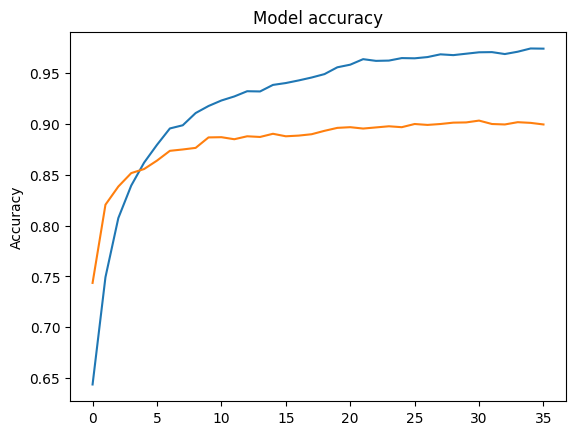

In [ ]:
# Generate a graph to visualize learning over epochs
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')

### CNN

In [ ]:
X_train.shape

(17889, 1200)

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, GlobalMaxPooling1D, Dense, Dropout, Add
from tensorflow.keras.models import Model

num_documents = X_train.shape[0]
num_features = X_train.shape[1]

X_train_cnn = X_train[..., np.newaxis]


# Reshape DTM for CNN (add channel dimension)
X_train_cnn = X_train[..., np.newaxis]  # Shape: (num_documents, num_features, 1)

# Input layer
inputs = Input(shape=(num_features, 1))

# Block 1
x = Conv1D(128, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv1D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = GlobalMaxPooling1D()(x)

# Block 2 (Residual connection)
residual = x  # Save the input for the residual connection
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Add()([x, residual])  # Add residual connection

# Output layer
outputs = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
# model.summary()


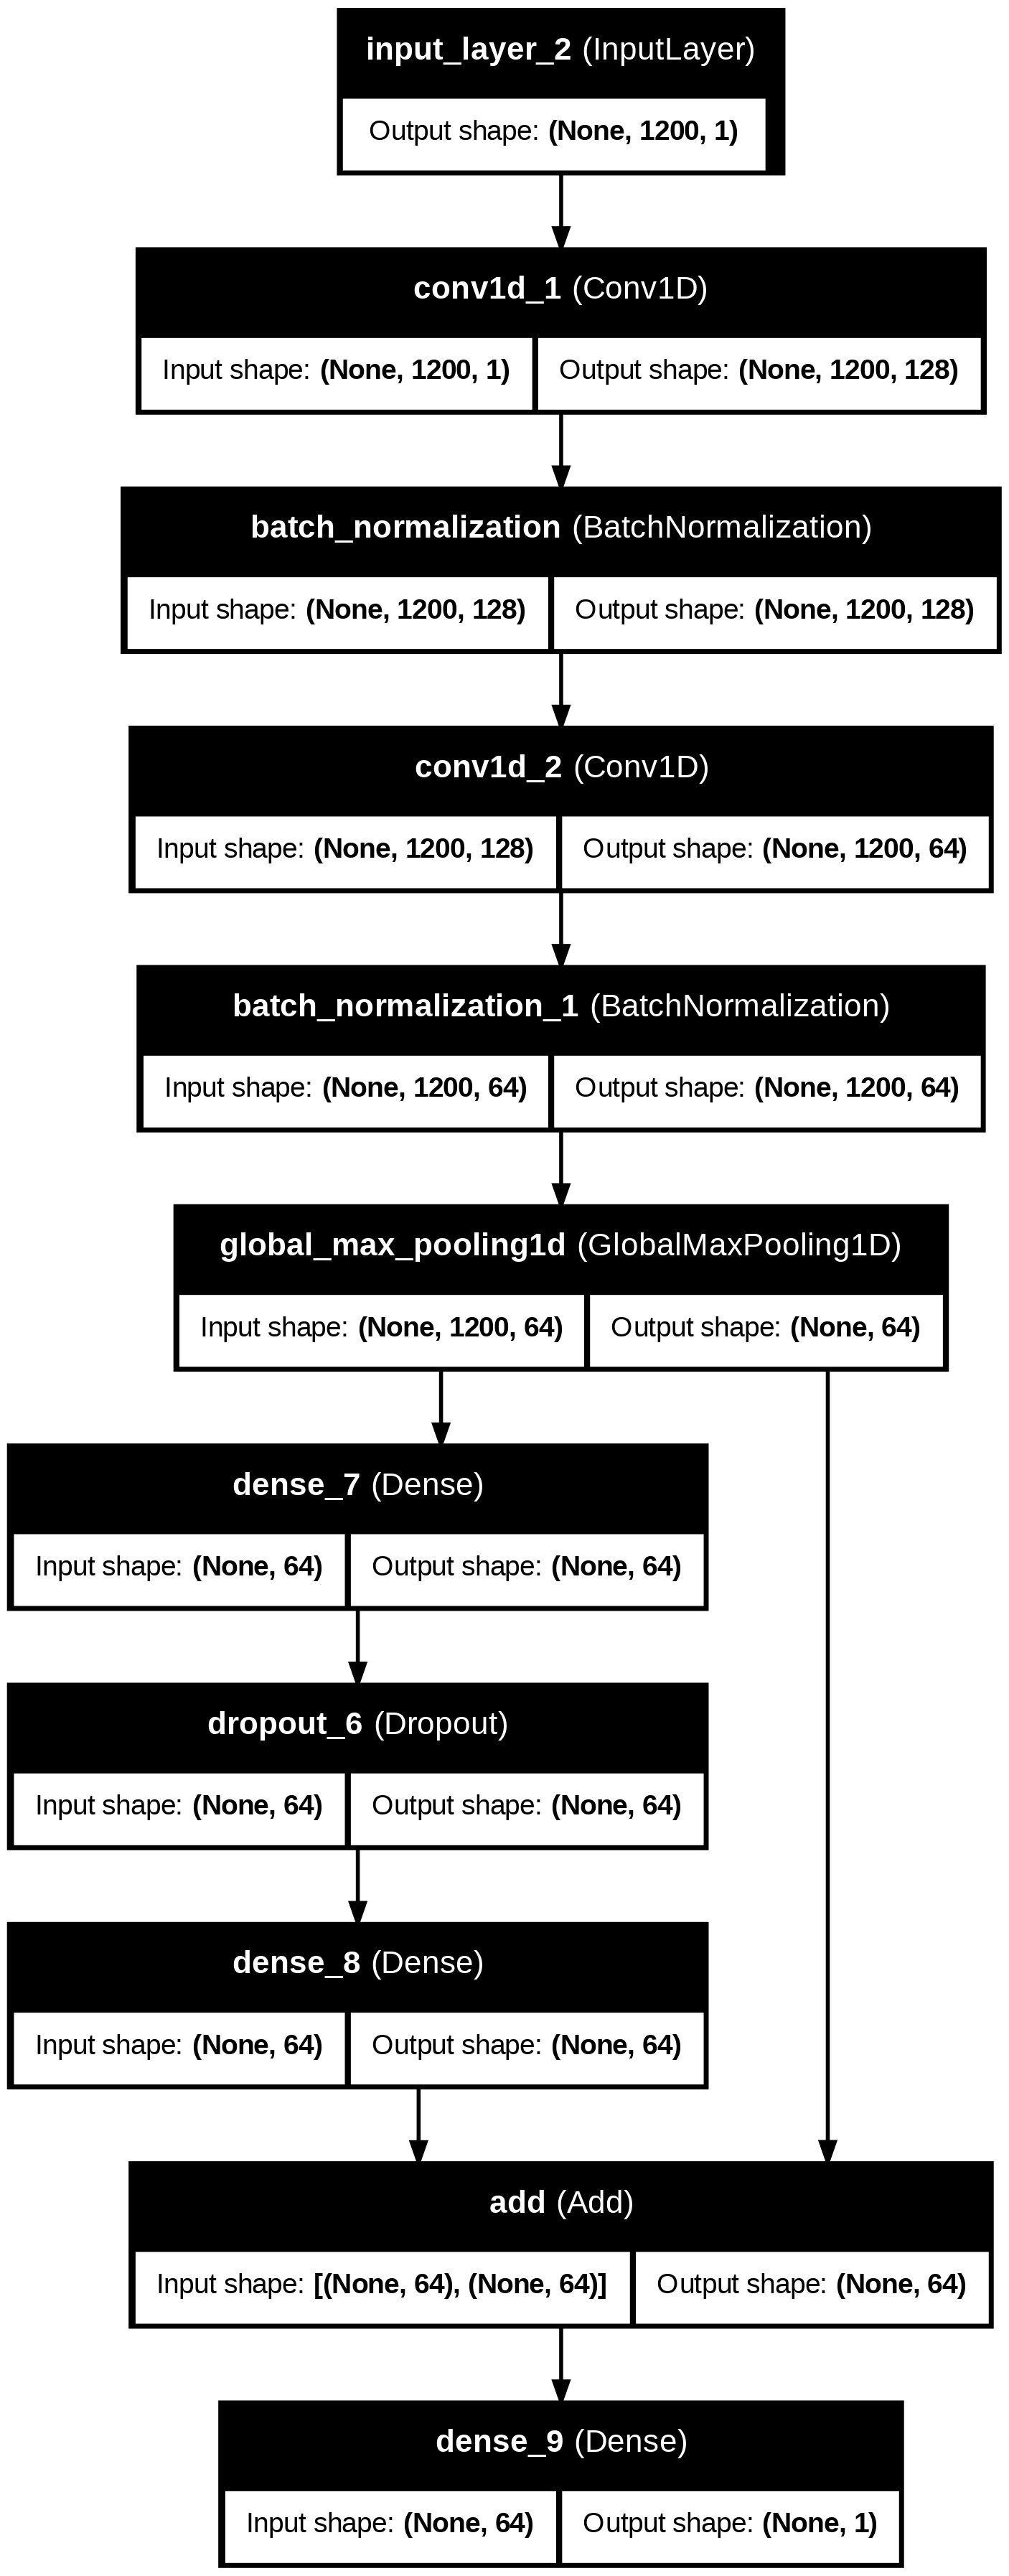

In [ ]:
# Model visualization
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train model
history = model.fit(
    X_train_cnn, y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],
    batch_size=32
)

Epoch 1/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 202s 357ms/step - accuracy: 0.6307 - loss: 1.3756 - val_accuracy: 0.6179 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 2/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 188s 335ms/step - accuracy: 0.6614 - loss: 0.7276 - val_accuracy: 0.6830 - val_loss: 0.6067 - learning_rate: 0.0010
Epoch 3/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 182s 325ms/step - accuracy: 0.6797 - loss: 0.6382 - val_accuracy: 0.5949 - val_loss: 0.6946 - learning_rate: 0.0010
Epoch 4/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 199s 320ms/step - accuracy: 0.6759 - loss: 0.6580 - val_accuracy: 0.6410 - val_loss: 0.6332 - learning_rate: 0.0010
Epoch 5/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 180s 322ms/step - accuracy: 0.6791 - loss: 0.6436 - val_accuracy: 0.7000 - val_loss: 0.5977 - learning_rate: 0.0010


In [ ]:
# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.6194 - loss: 0.6897
Test Loss: 0.6910843849182129, Test Accuracy: 0.6179298162460327


## LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

# Reshape the input data for LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))) #input_shape = (timesteps, features)
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


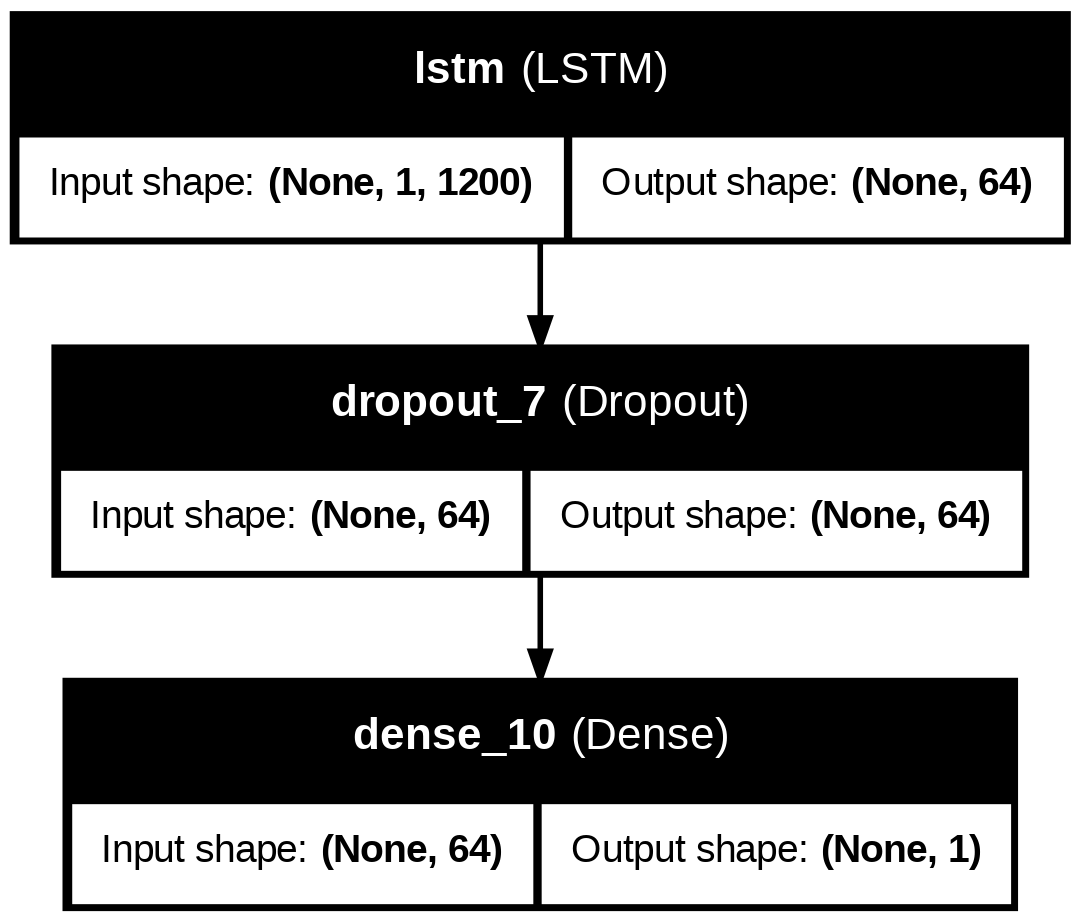

In [ ]:
# Model Visualization
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7067 - loss: 0.5903 - val_accuracy: 0.8350 - val_loss: 0.4019 - learning_rate: 0.0010
Epoch 2/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8643 - loss: 0.3392 - val_accuracy: 0.8645 - val_loss: 0.3380 - learning_rate: 0.0010
Epoch 3/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9092 - loss: 0.2473 - val_accuracy: 0.8761 - val_loss: 0.3133 - learning_rate: 0.0010
Epoch 4/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9225 - loss: 0.2111 - val_accuracy: 0.8869 - val_loss: 0.3036 - learning_rate: 0.0010
Epoch 5/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9319 - loss: 0.1892 - val_accuracy: 0.8889 - val_loss: 0.3049 - learning_rate: 0.0010
Epoch 6/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9422 - loss: 0.1607 - val_accuracy: 0.8891 - val_loss: 0.3067 - learning_rate: 0.0010
Epoch 7/100
560/560 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9470 - lo

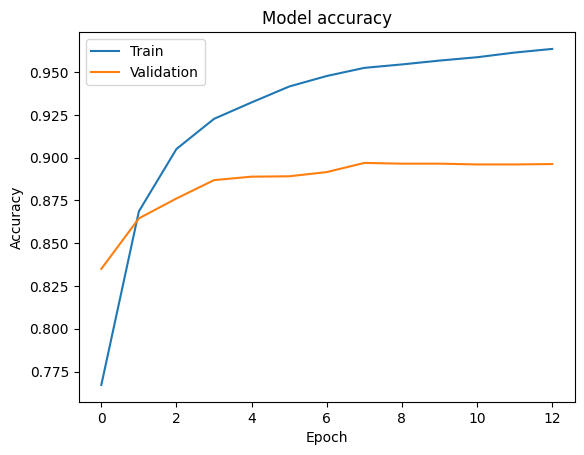

In [ ]:
# Train the model
history = model.fit(
    X_train_lstm, y_train,
    epochs=100,
    validation_data=(X_test_lstm, y_test),
    callbacks=[early_stopping, lr_scheduler],
    batch_size=32
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_lstm, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Make predictions
predictions = []
for pred in model.predict(X_test_lstm):
    if pred > 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

# Print classification report and confusion matrix
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

#Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Random Forest Fun

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8765928906773978


In [ ]:
# prompt: Make a gridsearch for random forest

from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

# Create a RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best score: 0.8568396811315321
Test Accuracy: 0.8792756539235412


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf = RandomForestClassifier(n_estimators=200,
                            max_depth=None,
                            min_samples_leaf=2,
                            min_samples_split=5,
                            random_state=101)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Classification Report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8788285267158507
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      2231
           1       0.85      0.93      0.88      2242

    accuracy                           0.88      4473
   macro avg       0.88      0.88      0.88      4473
weighted avg       0.88      0.88      0.88      4473

[[1851  380]
 [ 162 2080]]
